In [4]:
from typing import List, Tuple
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import numpy as np
plt.style.use('https://raw.githubusercontent.com/uhveg/matplotlibStyles/main/thesis.mplstyle')
prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [7]:
def csch(x:float) -> float:
    if x == 0:
        return float('inf')
    return 1 / np.sinh(x)

def signed_area(pi:np.ndarray, pj:np.ndarray, pk:np.ndarray) -> float:
        if len(pi.shape) < 2:
             pi, pj, pk = pi[:,np.newaxis], pj[:,np.newaxis], pk[:,np.newaxis]
        lij = pi[:2] - pj[:2]
        lik = pi[:2] - pk[:2]
        I = np.array([[0,1],[-1,0]])
        return (0.5 * lij.T @ I @ lik).item()

def drawbot(x:float, y:float, theta:float, b:float = 0.05) -> PatchCollection:
    circle = mpatches.Circle((x, y), 0.08, ec='k', fill=False)
    wl = np.array([[- 0.05],[- 0.015 + 0.07]])
    wr = np.array([[- 0.05],[- 0.015 - 0.07]])
    wl = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])@wl + np.array([[x],[y]])
    wr = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])@wr + np.array([[x],[y]])
    circle_b = mpatches.Circle((x+b*np.cos(theta), y+b*np.sin(theta)), 0.01, ec='k', fc='r', fill=True)

    wheel_l = mpatches.Rectangle((wl[0][0], wl[1][0]), 0.1, 0.03, angle=theta*180/np.pi, fill=True, ec="k", fc="w")
    wheel_r = mpatches.Rectangle((wr[0][0], wr[1][0]), 0.1, 0.03, angle=theta*180/np.pi, fill=True, ec="k", fc="w")
    return PatchCollection([circle, wheel_l, wheel_r, circle_b], match_original=True)

In [8]:
class Robot:
    def __init__(self, id:int, p0:np.ndarray = np.zeros((3,1)), c:str = "#ff0000") -> None:
        self.position = p0 # x, y, theta ->
        self.b = 0.05
        self.T = np.array([
            [np.cos(self.position[2][0]), np.sin(self.position[2][0])],
            [-np.sin(self.position[2][0])/self.b, np.cos(self.position[2][0])/self.b]
        ])
        self.vw = np.zeros((2,1)) # zeros
        self.neighbors:List[Tuple[Robot, float]] = []
        self.triplets:List[Tuple[int, int, float]] = []
        self.posB = np.array([
            [self.position[0][0] + self.b*np.cos(self.position[2][0])],
            [self.position[1][0] + self.b*np.sin(self.position[2][0])]
        ])
        self.positions = np.copy(self.position)
        self.POSB = np.copy(self.posB)
        self.color = c
        self.id = id
        self.vel = np.copy(self.vw)

    def link(self, rb:'Robot', k:float):
        self.neighbors.append((rb, k))
        rb.neighbors.append((self, k))
    
    def add_triplet(self, triplet:Tuple[int, int, float]):
        j, k = self.get_neighbor(triplet[0]), self.get_neighbor(triplet[1])
        if j is not None and k is not None:
            self.triplets.append(triplet)
            j.triplets.append((k.id, self.id, triplet[2]))
            k.triplets.append((self.id, j.id, triplet[2]))
        else:
            print("NOT NEIGHBOR")

    def get_neighbor(self, index:int) -> 'Robot | None':
        for n,_ in self.neighbors:
            if n.id == index:
                return n
        return None

    def has_neighbor(self, index:int) -> bool:
        for n,_ in self.neighbors:
            if n.id == index:
                return True
        return False
    
    def control_csch(self):
        if self.vw is None:
            self.vw = np.zeros((2,1))
        alpha, delta = 1.0, 0.2
        U = np.zeros((2,1))
        for neigh in self.neighbors:
            k_g = neigh[1]
            l = self.posB - neigh[0].posB
            norm_l:float = float(np.linalg.norm(l))
            if norm_l <= 0:
                print(f"Error {self.id} - {neigh[0].id}")
            csch_ = csch((norm_l - delta) / k_g)
            w = alpha*(1 - (1/(k_g * norm_l))*csch_**2)
            U -= w*l
        self.vw += self.T @ U

    def control_sgd(self):
        if self.vw is None:
            self.vw = np.zeros((2,1))
        Uci = np.zeros((2,1))
        K = 8.0
        I = np.array([[0,1],[-1,0]])
        for triplet in self.triplets:
            neigh_j = self.get_neighbor(triplet[0])
            neigh_k = self.get_neighbor(triplet[1])
            Z_STR = triplet[2]
            Z_ijk = signed_area(self.posB, neigh_j.posB, neigh_k.posB)
            ljk = neigh_j.posB[:2] - neigh_k.posB[:2]
            Uci -= K*(Z_ijk - Z_STR) * I @ ljk
        self.vw += self.T @ Uci

    def update(self, dt:float):
        self.vw *= 0.5
        self.vw[0][0] = 0.2 if self.vw[0][0]>0.2 else -0.2 if self.vw[0][0]<-0.2 else self.vw[0][0]
        self.vw[1][0] = 0.9 if self.vw[1][0]>0.9 else -0.9 if self.vw[1][0]<-0.9 else self.vw[1][0]
        self.position[0] += dt*np.cos(self.position[2][0])*self.vw[0]
        self.position[1] += dt*np.sin(self.position[2][0])*self.vw[0]
        self.position[2] += dt*self.vw[1]
        self.posB = np.array([
            [self.position[0][0] + self.b*np.cos(self.position[2][0])],
            [self.position[1][0] + self.b*np.sin(self.position[2][0])]
        ])
        self.T = np.array([
            [np.cos(self.position[2][0]), np.sin(self.position[2][0])],
            [-np.sin(self.position[2][0])/self.b, np.cos(self.position[2][0])/self.b]
        ])
        self.positions = np.hstack((self.positions, self.position))
        self.POSB = np.hstack((self.POSB, self.posB))
        self.vel = np.hstack((self.vel, self.vw))
        self.vw = None

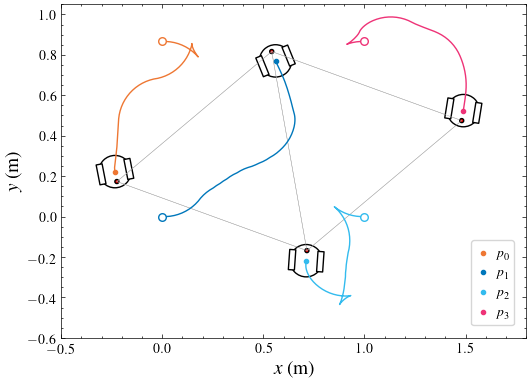

In [9]:
colors = ["#43BCCD", "#EA3546", "#662E9B", "#678D58", "#2B061E", "#D2BF55"]
r1 = Robot(0, np.array([[0.0,np.sqrt(0.75),0.0]]).T, colors[0])
r2 = Robot(1, np.array([[0.0,0.0,0.0]]).T, colors[1])
r3 = Robot(2, np.array([[1.0,0.0,0.0]]).T, colors[2])
r4 = Robot(3, np.array([[1.0,np.sqrt(0.75),0.0]]).T, colors[3])
all_rbts = [r1,r2,r3,r4]

# add links in the network, with respective gains
x = 0.85175781
all_rbts[0].link(all_rbts[1], x)
all_rbts[0].link(all_rbts[2], x)
all_rbts[1].link(all_rbts[2], x)
all_rbts[1].link(all_rbts[3], x)
all_rbts[2].link(all_rbts[3], x)

# add triplets in the network, with desired values
all_rbts[0].add_triplet((1, 2, -0.43301))
all_rbts[1].add_triplet((3, 2, -0.43301))

# Simulation via euler integration
t, dt = 0, 0.1
while t < 15:
    t += dt
    for i in range(4):
        all_rbts[i].control_csch()
        all_rbts[i].control_sgd()
    for i in range(4):
        all_rbts[i].update(dt)

fig, ax = plt.subplots()
ax: plt.Axes

for i in range(4):
    color = prop_cycle[i]
    ax.scatter(all_rbts[i].positions[0,0], all_rbts[i].positions[1,0], facecolor="white", edgecolor=color, marker="o", zorder=3, s=30)
    ax.plot(all_rbts[i].positions[0,:], all_rbts[i].positions[1,:], color=color, linestyle="-", zorder=2)
    ax.scatter(all_rbts[i].positions[0,-1], all_rbts[i].positions[1,-1], color=color, marker="o",label=rf"$p_{all_rbts[i].id}$", zorder=2)
    ax.add_collection(drawbot(all_rbts[i].positions[0,-1],all_rbts[i].positions[1,-1],all_rbts[i].positions[2,-1]))


    for neigh in all_rbts[i].neighbors:
        ax.plot([all_rbts[i].posB[0],neigh[0].posB[0]], [all_rbts[i].posB[1],neigh[0].posB[1]], linewidth=0.3, color="#aaaaaa", zorder=1)

plt.legend(loc='lower right')
ax.set_xlabel(r"$x$ (m)")
ax.set_ylabel(r"$y$ (m)")
ax.set_xlim((-0.5, 1.8))
ax.set_ylim((-0.6, 1.05))
ax.set_aspect("equal")
# plt.savefig('images/tsim_trajectory.pdf')
plt.show()

In [10]:
edges = dict()
edges_err = dict()
for i in range(4):
    for r, _ in all_rbts[i].neighbors:
        link = f"{all_rbts[i].id}{r.id}"
        if link not in edges.keys() and link[::-1] not in edges.keys():
            edges[link] = np.linalg.norm(all_rbts[i].POSB[:2,:] - r.POSB[:2,:], axis=0)
            edges_err[link] = edges[link] - 1.0
            
areas = dict()
areas_err = dict()
for i in range(4):
    for triplet in all_rbts[i].triplets:
        tri_str = [f"{all_rbts[i].id}{triplet[0]}{triplet[1]}", f"{triplet[1]}{all_rbts[i].id}{triplet[0]}", f"{triplet[0]}{triplet[1]}{all_rbts[i].id}"]
        if tri_str[0] not in areas.keys() and tri_str[1] not in areas.keys() and tri_str[2] not in areas.keys():
            PI, PJ, PK = all_rbts[i].POSB.T, all_rbts[triplet[0]].POSB.T, all_rbts[triplet[1]].POSB.T
            areas[tri_str[0]] = np.array([signed_area(pi, pj, pk) for pi, pj, pk in zip(PI,PJ,PK)])
            areas_err[tri_str[0]] = areas[tri_str[0]] - triplet[2]

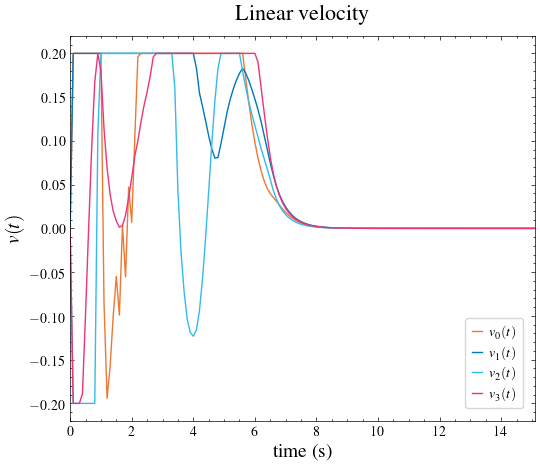

In [11]:
# LINEAR VELOCITY
fig, ax = plt.subplots(figsize=(6,5))
ax: plt.Axes
for i in range(4):
    ax.plot(np.linspace(0,t,all_rbts[i].vel[0].size), all_rbts[i].vel[0], prop_cycle[i], label=f"$v_{i}(t)$")
ax.set_xlabel(r"time (s)")
ax.set_ylabel(r"$v(t)$")
ax.set_xlim((0,t))
ax.set_title("Linear velocity")
plt.legend(loc='lower right')
# plt.savefig('images/tsim_lvel.pdf')
plt.show()

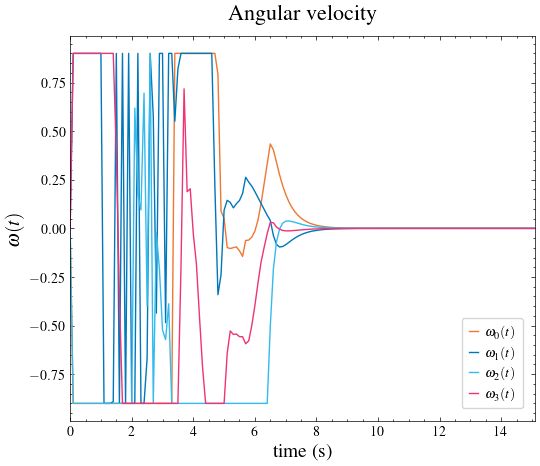

In [14]:
# ANGULAR VELOCITY
fig, ax = plt.subplots()
ax: plt.Axes
for i in range(4):
    ax.plot(np.linspace(0,t,all_rbts[i].vel[1].size), all_rbts[i].vel[1], prop_cycle[i], label=f"$\omega_{i}(t)$")
ax.set_xlabel(r"time (s)")
ax.set_ylabel(r"$\omega (t)$")
ax.set_xlim((0,t))
ax.set_title("Angular velocity")
plt.legend(loc='lower right')
# plt.savefig('images/tsim_avel.pdf')
plt.show()

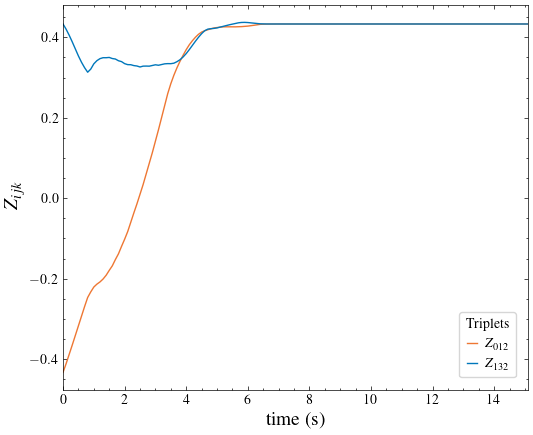

In [15]:
# Areas error
fig, ax = plt.subplots()
ax: plt.Axes
for i, a in enumerate(areas.keys()):
    ax.plot(np.linspace(0,t,len(areas[a])), -areas[a], prop_cycle[i], label=f"$Z_{{{a}}}$")
ax.set_xlabel(r"time (s)")
ax.set_ylabel(r"$Z_{ijk}$")
ax.set_xlim((0,t))
# ax.set_title("Signed Area")
plt.legend(title="Triplets")
# plt.savefig('images/tsim_areas.pdf')
plt.show()

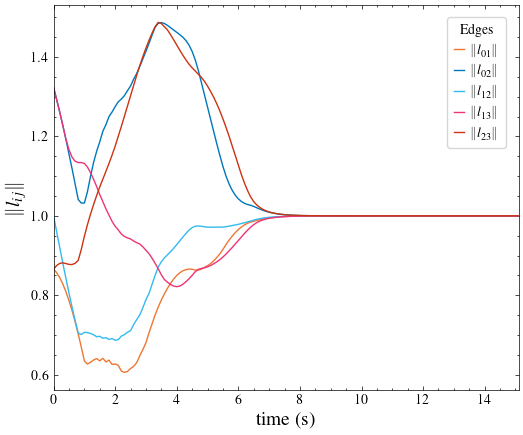

In [16]:
# Edge length errors
fig, ax = plt.subplots()
ax: plt.Axes
for i, e in enumerate(edges.keys()):
    ax.plot(np.linspace(0,t,len(edges[e])), edges[e], prop_cycle[i], label=fr"$\lVert l_{{{e}}} \rVert$")
ax.set_xlabel(r"time (s)")
ax.set_ylabel(r"$\lVert l_{ij} \rVert$")
ax.set_xlim((0,t))
# ax.set_title("Robots' distance")
plt.legend(title="Edges")
# plt.savefig('images/tsim_edges.pdf')
plt.show()

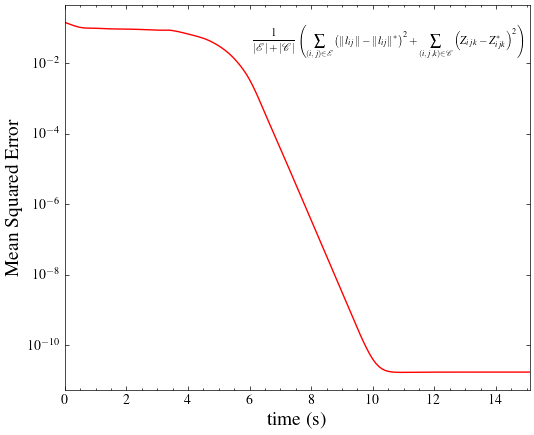

In [24]:
# MSE 
fig, ax = plt.subplots()
ax: plt.Axes
MSE = np.zeros((len(edges_err[e]),))
for e in edges_err.keys():
    MSE += edges_err[e]**2
for a in areas_err.keys():
    MSE += areas_err[a]**2
MSE /= len(edges_err.keys()) + len(areas_err.keys())
ax.plot(np.linspace(0,t,len(MSE)), MSE, color='red')
ax.set_xlabel(r"time (s)")
# ax.set_ylabel(r"$\lVert l_{ij} \rVert$")
ax.set_xlim((0,t))
ax.set_ylabel("Mean Squared Error")
plt.text(0.99, 0.95, r"$\displaystyle \frac{1}{|\mathcal E|+|\mathcal C|}\left( \sum_{(i,j)\in \mathcal E}\left ( \lVert l_{ij} \rVert - \lVert l_{ij} \rVert^* \right )^2 + \sum_{(i,j,k)\in \mathcal C} \left ( Z_{ijk} -  Z_{ijk}^* \right )^2\right)$", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
plt.yscale('log')
# plt.savefig('images/tsim_mse.pdf')
plt.show()

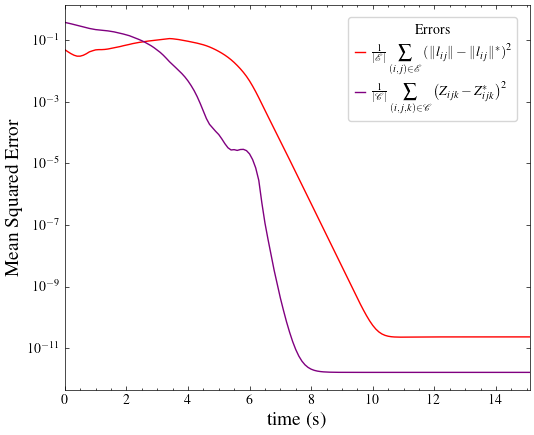

In [34]:
# MSE 
fig, ax = plt.subplots()
ax: plt.Axes
MSE_e = np.zeros((len(edges_err[list(edges_err.keys())[0]]),))
MSE_a = np.zeros((len(areas_err[list(areas_err.keys())[0]]),))
for e in edges_err.keys():
    MSE_e += edges_err[e]**2
for a in areas_err.keys():
    MSE_a += areas_err[a]**2
MSE_e /= len(edges_err.keys())
MSE_a /= len(areas_err.keys())
ax.plot(np.linspace(0,t,len(MSE_e)), MSE_e, color="red", label=r"$\displaystyle \tfrac{1}{|\mathcal E|}\sum_{(i,j)\in \mathcal E} \left ( \lVert l_{ij} \rVert - \lVert l_{ij} \rVert^* \right )^2$")
ax.plot(np.linspace(0,t,len(MSE_a)), MSE_a, color="purple", label=r"$\displaystyle \tfrac{1}{|\mathcal C|}\sum_{(i,j,k)\in \mathcal C} \left ( Z_{ijk} -  Z_{ijk}^* \right )^2$")
ax.set_xlabel(r"time (s)")
ax.set_xlim((0,t))
ax.set_ylabel("Mean Squared Error")
plt.yscale('log')
plt.legend(title="Errors")
# plt.savefig('images/tsim_mse_sep.pdf')
plt.show()